In [1]:
%matplotlib inline

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

import scipy.ndimage as nd
import scipy.spatial
from scipy.optimize import minimize

from stsci.convolve import convolve2d
from skimage.transform import warp
from skimage.transform import SimilarityTransform
from skimage.morphology import dilation
from skimage.morphology import binary_dilation

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
import astropy.units as u

from photutils import create_matching_kernel
from photutils import (HanningWindow, TukeyWindow, CosineBellWindow,
                       SplitCosineBellWindow, TopHatWindow)

import drizzlepac
from drizzlepac.astrodrizzle import ablot

from grizli import utils

# Need to move these to public repo
from golfir import irac 
from golfir.utils import get_wcslist, _obj_shift

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


In [3]:
# Uses products from IRAC-mosaic.ipynb notebook
root = 'j025708m2326'

PATH = '/Users/gbrammer/Research/HST/CHArGE/IRAC/'+root
try:
    os.mkdir(PATH)
except:
    pass

os.chdir(PATH)

In [4]:
# Interactive with DS9 (uses pyds9)
from grizli import ds9
ds9 = ds9.DS9()

In [5]:
# Windowing for PSF match
window = HanningWindow()

In [6]:
###############
# HST Images
ref_file = glob.glob('{0}-f1*_drz_sci.fits'.format(root)) 
ref_file += glob.glob('{0}-ir*sci.fits'.format(root))

ref_file.sort()
ref_file = ref_file[-1]

print(f'HST reference file: {ref_file}')

hst_im = pyfits.open(ref_file)
ref_filter = utils.get_hst_filter(hst_im[0].header).lower()
hst_wht = pyfits.open(ref_file.replace('_sci', '_wht'))
hst_psf = pyfits.open('{0}-{1}_psf.fits'.format(root, 'f160w'))[1].data

if os.path.exists('star_psf.fits'):
    st = pyfits.open('star_psf.fits')
    hst_psf = st['OPSF','F160W'].data*1

hst_psf /= hst_psf.sum()

hst_seg = pyfits.open(root+'-ir_seg.fits')[0]
hst_ujy = hst_im[0].data*hst_im[0].header['PHOTFNU'] * 1.e6
hst_wcs = pywcs.WCS(hst_im[0].header)

phot = utils.read_catalog('{0}_irac_phot.fits'.format(root))

#########################
# Watershed dilation of the segmentation maps to make regions larger
from skimage.morphology import watershed
from astropy.convolution.kernels import Gaussian2DKernel
kern = Gaussian2DKernel(5).array

med = np.median(hst_im[0].data[(hst_wht[0].data > 0) & (hst_seg.data == 0)])
hst_conv = convolve2d(hst_im[0].data-med, kern, fft=1)
hst_var = 1/hst_wht[0].data
wht_med = np.percentile(hst_wht[0].data[hst_wht[0].data > 0], 5)
hst_var[hst_wht[0].data < wht_med] = 1/wht_med
hst_cvar = convolve2d(hst_var, kern**2, fft=1)

xi = np.cast[int](np.round(phot['xpeak']))
yi = np.cast[int](np.round(phot['ypeak']))
markers = np.zeros(hst_im[0].data.shape, dtype=int)
markers[yi, xi] = phot['number']

waterseg = watershed(-hst_conv, markers, mask=(hst_conv/np.sqrt(hst_cvar) > 1))
waterseg[waterseg == 0] = hst_seg.data[waterseg == 0]

HST reference file: j025708m2326-ir_drz_sci.fits


In [7]:
if ds9 is not None:
    ds9.frame(1)
    ds9.set(f'file {ref_file}')
    ds9.set_defaults(match='wcs')
    ds9.frame(2)
    ds9.set(f'file {root}-ir_seg.fits')
    
    if root == 'j025708m2326':
        ds9.set('pan to 44.27983012 -23.43852795 fk5')

In [8]:
# Spitzer channel to fit (integers for IRAC, 'mips1' for 24um)
ch = 1

In [9]:
################
# Parameters for IRAC fitting
USE_AVG_PSF=True
if USE_AVG_PSF:
    avg_psf = pyfits.open('{0}-ch{1}-0.1.psfr_avg.fits'.format(root, ch))[0].data
else:
    avg_psf=None

avg_kern = None #np.ones((5,5))
hst_psf_offset = [2,2]
hst_psf_size = hst_psf.shape[0]//2

# Masks around Bright stars 
try:
    _ = bright_limits
    bright_ids = None
except:
    bright_limits = [16,19]
    bright_ids = None

bright_sn = 3

###############
# Load Spitzer images
if ch == 'mips1':
    irac_im = pyfits.open('{0}-{1}_drz_sci.fits'.format(root, ch))[0]
    irac_wht = pyfits.open('{0}-{1}_drz_wht.fits'.format(root, ch))[0].data
    irac_psf_obj = irac.MipsPSF()
    pf = 10 # assume 1" pixels

    column_root = 'mips_24'
    phot['{0}_flux'.format(column_root)] = -99.
    phot['{0}_err'.format(column_root)] = -99.
    phot['{0}_bright'.format(column_root)] = 0

    bright_limits = None
    #ERR_SCALE = 0.1828 # From residuals
    ch_label = ch
    ERR_SCALE = 1.

else:
    irac_im = pyfits.open('{0}-ch{1}_drz_sci.fits'.format(root, ch))[0]
    irac_wht = pyfits.open('{0}-ch{1}_drz_wht.fits'.format(root, ch))[0].data
    irac_psf_obj = irac.IracPSF(ch=ch, scale=0.1, verbose=True, avg_psf=avg_psf)
    
    ERR_SCALE = 1.
    if os.path.exists('{0}-ch{1}.cat.fits'.format(root, ch)):
        ir_tab = utils.read_catalog('{0}-ch{1}.cat.fits'.format(root, ch))
        if 'ERR_SCALE' in ir_tab.meta:
            ERR_SCALE = ir_tab.meta['ERR_SCALE']
    
    # Integer ratio of pixel sizes between IRAC and HST
    try:
        irac_wcs = pywcs.WCS(irac_im.header)
        pscale = utils.get_wcs_pscale(irac_wcs)
        pf = int(np.round(pscale/0.1))
    except:
        pf = 5

    column_root = 'irac_ch{0}'.format(ch)        
    phot['{0}_flux'.format(column_root)] = -99.
    phot['{0}_err'.format(column_root)] = -99.
    phot['{0}_bright'.format(column_root)] = 0
    ch_label = 'ch{0}'.format(ch)

Read PSF data r37857024-ch1.log.fits / r37857024-ch1-0.1.psf.fits
Read PSF data r37857280-ch1.log.fits / r37857280-ch1-0.1.psf.fits
Use rotated `avg_psf`.


In [10]:
### (Restart from here after computing alignment below)

##################
# HST PSF in same dimensions as IRAC
tf=None
rd = hst_wcs.wcs.crval
_psf, _, _ = irac_psf_obj.evaluate_psf(ra=rd[0], dec=rd[1], 
                              min_count=1, clip_negative=True, 
                              transform=tf)

hst_psf_full = np.zeros_like(_psf)
sh_irac = hst_psf_full.shape
hslx = slice(sh_irac[0]//2+hst_psf_offset[0]-hst_psf_size, sh_irac[0]//2+hst_psf_offset[0]+hst_psf_size)
hsly = slice(sh_irac[0]//2+hst_psf_offset[1]-hst_psf_size, sh_irac[0]//2+hst_psf_offset[1]+hst_psf_size)
hst_psf_full[hsly, hslx] += hst_psf

# IRAC WCS
irac_wcs = pywcs.WCS(irac_im.header)

# not used
mx = my = None

# HST weight in IRAC frame
hst_wht_i = hst_wht[0].data[::pf, ::pf]
ll = np.cast[int](irac_wcs.all_world2pix(hst_wcs.all_pix2world(np.array([[-0.5, -0.5]]), 0), 0)).flatten()
irac_mask = np.zeros(irac_im.data.shape)
isly = slice(ll[1], ll[1]+hst_wht_i.shape[0])
islx = slice(ll[0], ll[0]+hst_wht_i.shape[1])
irac_wht[isly, islx] *= hst_wht_i > 0
irac_sivar = np.sqrt(irac_wht)/ERR_SCALE

tf = None

In [11]:
# Test at the center of the image as displayed in DS9

# Initial small patch
get_pan, patch_arcmin = True, 0.4

# Full patch around WFC3/IR
#get_pan, patch_arcmin = True, 1.4

Npan = int(patch_arcmin*60*10/pf)
print(patch_arcmin, Npan)

0.4 48


In [12]:
##################################
##################################
# Big script to run the modeling

# Get the DS9 pan position
if get_pan:
    
    rd_pan = np.cast['float'](ds9.get('pan fk5').split())
    
    xy_irac = np.cast[int](np.round(irac_wcs.all_world2pix(np.array([rd_pan]), 0))).flatten()
    
    ll_irac = xy_irac-Npan
    ll_hst_raw = hst_wcs.all_world2pix(irac_wcs.all_pix2world(np.array([xy_irac-Npan])-0.5, 0), 0)
    ll_hst = np.cast[int](np.ceil(ll_hst_raw)).flatten()
    
    #Npan = 256
    slx = slice(ll_hst[0], ll_hst[0]+2*Npan*pf)
    sly = slice(ll_hst[1], ll_hst[1]+2*Npan*pf)

    if False:
        print('Dilate segmentation image')
        
        seg_sl = hst_seg.data[sly, slx]*1
        ids = np.unique(seg_sl)[1:]
        in_seg = utils.column_values_in_list(phot['number'], ids) & (phot['mag_auto'] < 26)
        in_seg &= np.isfinite(phot[ref_filter+'_fluxerr_aper_1'])
        in_seg &= phot[ref_filter+'_fluxerr_aper_1'] > 0
        
        so = np.argsort(phot['mag_auto'][in_seg])
        
        sizes = np.clip(np.cast[int](np.sqrt(phot['npix'])), 2, 64)
        so = np.argsort(sizes[in_seg])[::-1]
        
        for iter in range(3):
            for id, mag, si in zip(phot['number'][in_seg][so], phot['mag_auto'][in_seg][so], sizes[in_seg][so]):
                #break
                #si = np.clip(np.cast[int](1.8**(26-np.clip(mag, 18, 25))), 3, 32)
                print('{0} {1:.2f} {2}'.format(id, mag, si))
                seg_dilate = np.zeros((si, si))
                seg_dilate[si//2,:] = 1
                seg_dilate[:,si//2] = 1

                dil_id = binary_dilation(seg_sl == id, seg_dilate)
                seg_sl[(seg_sl == 0) & dil_id] = id
        
        ds9.frame(10)
        ds9.view(seg_sl, header=utils.to_header(hst_wcs.slice((sly, slx))))
    else:
        #seg_sl = hst_seg.data[sly, slx]*1
        seg_sl = waterseg[sly, slx]*1
        ds9.frame(10)
        ds9.view(seg_sl, header=utils.to_header(hst_wcs.slice((sly, slx))))

# What IDs are we fitting here?
ids = np.unique(seg_sl)[1:]
N = len(ids)

islx = slice(ll_irac[0], ll_irac[0]+2*Npan)
isly = slice(ll_irac[1], ll_irac[1]+2*Npan)

print('Compute object models (N={0})'.format(N))

# Generate position-specific PSF for each source
source_psf = True

if source_psf:
    # Evaluate PSF at each position
    _A = []
    hst_slice = hst_ujy[sly, slx]
    for i, id in enumerate(ids):
        print(i, id)
        ix = phot['number'] == id
        
        if mx is not None:
            rx_i = mx(phot['ra'][ix]-m0[0], phot['dec'][ix]-m0[1])
            ry_i = my(phot['ra'][ix]-m0[0], phot['dec'][ix]-m0[1])
            tf = np.array([rx_i, ry_i]) #{'translation':(rx_i, ry_i)}

        else:
            #tf = {'translation':(rx, ry)}
            tf = None
            
        _ = irac_psf_obj.evaluate_psf(ra=phot['ra'][ix], dec=phot['dec'][ix], min_count=0, 
                                      clip_negative=True, transform=tf)

        irac_psf, psf_exptime, psf_count = _                              
        if window is -1:
            psf_kernel = irac_psf
        else:
            psf_kernel = create_matching_kernel(hst_psf_full, irac_psf, window=window)

        # Extra factor for rebinning pixel grids, assuming 5x oversampling
        if avg_kern is not None:
            psf_kernel = convolve2d(psf_kernel, avg_kern, mode='constant', fft=1, cval=0.)
        else:
            psf_kernel *= pf**2
            
        _Ai = convolve2d(hst_slice*(seg_sl == id), psf_kernel,
                          mode='constant', fft=1)[::pf, ::pf].flatten()
        _A.append(_Ai)                 
    
    _A = np.array(_A)
        
else:
    try:
        _ = rd_pan
    except:
        rd_pan = hst_wcs.wcs.crval

    #if tf is None:
    #    tf = {'translation':(rx, ry)}
        
    _ = irac_psf_obj.evaluate_psf(ra=rd_pan[0], dec=rd_pan[1], 
                                  min_count=1, clip_negative=True, 
                                  transform=tf)

    irac_psf, psf_exptime, psf_count = _                              

    if window is -1:
        psf_kernel = irac_psf
    else:
        psf_kernel = create_matching_kernel(hst_psf_full, irac_psf, window=window)
    
    # Extra factor for rebinning pixel grids, assuming 5x oversampling
    if avg_kern is not None:
        psf_kernel = convolve2d(psf_kernel, avg_kern, mode='constant', cval=1., fft=1)
    else:
        psf_kernel *= pf**2
        
    _A = []
    for i, id in enumerate(ids):
        print(i, id)
        _Ai = convolve2d(hst_slice*(seg_sl == id), psf_kernel,
                          mode='constant', fft=1)[::pf, ::pf].flatten()
        _A.append(_Ai)
        
    _A = np.array(_A) #np.array([convolve2d(hst_ujy[sly, slx]*(seg_sl == id), psf_kernel, mode='constant', fft=1)[::np, ::np].flatten() for id in ids])

# Arrays for fitting
y = irac_im.data[isly, islx].flatten()
sivar = (irac_sivar[isly, islx]).flatten()

# Simple model convolved with HST fluxes
h_sm = _A.sum(axis=0).reshape(seg_sl[::pf,::pf].shape)

# Renormalize so that coefficients are directly uJy
Anorm = _A.sum(axis=1)
keep = Anorm > 0
_A = (_A[keep,:].T/Anorm[keep]).T
ids = ids[keep]
Anorm = Anorm[keep]
N = keep.sum()

# Background components
from numpy.polynomial.chebyshev import chebgrid2d as polygrid2d
from numpy.polynomial.hermite import hermgrid2d as polygrid2d

#poly_order = 3
#poly_pix_size = 64
try:
    poly_order = np.clip(int(np.round(2*Npan/poly_pix_size)), 2, 11)
except:
    poly_order = np.clip(int(np.round(2*Npan/64)), 2, 11)
    
x = np.linspace(-1, 1, 2*Npan)
_Abg = []
c = np.zeros((poly_order, poly_order))
for i in range(poly_order):
    for j in range(poly_order):
        c*=0
        c[i][j] = 1.e-3
        _Abg.append(polygrid2d(x, x, c).flatten())
        
_Abg = np.array(_Abg)

# Redo transform fit from here
_Af = np.vstack([_Abg, _A])  
        
if bright_limits is not None:
    bright = (phot['mag_auto'][ids-1] < bright_limits[0]) #& (phot['flux_radius'][ids-1] < 1.5)  
    bright |= (phot['mag_auto'][ids-1] < bright_limits[1]) & (phot['flux_radius'][ids-1] < 3.5)  
    
    if bright_ids is not None:
        for ii in bright_ids:
            bright[ids == ii] = True
            
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0.
    bright = None

# Border
border = np.ones((2*Npan*pf, 2*Npan*pf))
yp, xp = np.indices((border.shape))
R = np.sqrt((xp+pf-Npan*pf)**2+(yp+pf-Npan*pf)**2)
border[1:-1,1:-1] = 0
#border = (R > Npan*np)*1
b_conv = convolve2d(border, psf_kernel,
                  mode='constant', fft=1, cval=1)[::pf, ::pf].flatten()
b_conv = b_conv/b_conv.max()
                  
msk = sivar > 0
msk &= h_bright*sivar < bright_sn
msk &= b_conv < 0.1
msk2d = msk.reshape(h_sm.shape)
_Ax = (_Af[:,msk]*(sivar)[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')

_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)

h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

Nbg = _Abg.shape[0]
h_bg = _Af[:Nbg].T.dot(_x[0][:Nbg]).reshape(h_sm.shape)

# IRAC image
ds9.frame(11)
ds9.view(h_sm, header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ds9.frame(12)
ds9.view(irac_im.data, header=irac_im.header)

ds9.frame(13)
ds9.view(msk2d*h_model, header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ds9.frame(14)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))
ds9.frame(15)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

get_pan = False

Compute object models (N=136)
0 234
1 238
2 242
3 243
4 245
5 247
6 249
7 254
8 257
9 262
10 263
11 266
12 268
13 269
14 274
15 279
16 281
17 284
18 285
19 286
20 287
21 302
22 303
23 305
24 310
25 312
26 315
27 316
28 317
29 319
30 324
31 325
32 329
33 330
34 336
35 340
36 348
37 352
38 363
39 365
40 370
41 371
42 372
43 373
44 375
45 377
46 378
47 387
48 392
49 393
50 394
51 395
52 396
53 397
54 398
55 404
56 420
57 421
58 422
59 423
60 425
61 429
62 435
63 436
64 437
65 438
66 439
67 440
68 441
69 445
70 446
71 447
72 449
73 451
74 453
75 460
76 464
77 467
78 472
79 479
80 480
81 481
82 482
83 484
84 492
85 493
86 498
87 499
88 514
89 533
90 534
91 541
92 544
93 546
94 551
95 554
96 563
97 564
98 566
99 574
100 575
101 578
102 579
103 580
104 588
105 593
106 594
107 595
108 597
109 598
110 601
111 605
112 607
113 609
114 610
115 611
116 612
117 616
118 618
119 626
120 628
121 629
122 630
123 633
124 634
125 635
126 636
127 652
128 660
129 661
130 663
131 666
132 669
133 674
134 708


In [13]:
# If you need to mask more sources, can adjust the limits here
# First value is AB magnitude below which anything is masked.  
# Second value is magnitude below which only things estimated to be point sources are masked.
# So, to match bright galaxies, increase the first number
# Starting point: bright_limits = [16,19]

bright_limits = [18, 19]

if bright_limits is not None:
    bright = (phot['mag_auto'][ids-1] < bright_limits[0]) #& (phot['flux_radius'][ids-1] < 1.5)  
    bright |= (phot['mag_auto'][ids-1] < bright_limits[1]) & (phot['flux_radius'][ids-1] < 3.5)  
    
    if bright_ids is not None:
        for ii in bright_ids:
            bright[ids == ii] = True
            
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0.
    bright = None

In [14]:
################################
# Realignment

# Fit for shift, rotation scale
t0 = np.array([0,0,0,1])*np.array([1,1,1,100.])

args = (irac_im.data[isly, islx], h_model, sivar.reshape(h_model.shape)*msk2d, 0)

_res = minimize(_obj_shift, t0, args=args, method='powell')

args = (irac_im.data[isly, islx], h_model, sivar.reshape(h_model.shape), 1)
tfx, warped = _obj_shift(_res.x, *args)
tf = tfx*1

# Modify PSF positioning
dd = np.cast[int](np.round(tf[:2]*pf))
print('PSF offset delta: ', dd, tf[:2])
hst_psf_offset -= dd

ds9.frame(16)
ds9.view(msk2d*(irac_im.data[isly, islx]-warped), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))   

# Shifts
if False:
    yp, xp = np.indices(irac_im.data.shape)
    yp = yp[isly, islx]
    xp = xp[isly, islx]
    _, xw = _obj_shift(_res.x,  irac_im.data[isly, islx], xp*1., sivar.reshape(h_model.shape), 1)
    _, yw = _obj_shift(_res.x,  irac_im.data[isly, islx], yp*1., sivar.reshape(h_model.shape), 1)
    
for i in range(_A.shape[0]):
    # print(i)
    _A[i,:] = irac.warp_image(tf, _A[i,:].reshape(h_model.shape)).flatten()

####################### Redo transformed model
_Af = np.vstack([_Abg, _A])  
    
# Bright stars
if bright is not None:
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0
    
msk = sivar > 0
msk &= b_conv < 0.1
msk &= h_bright*sivar < bright_sn
msk2d = msk.reshape(h_sm.shape)

_Ax = (_Af[:,msk]*sivar[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')

_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)

h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

Nbg = _Abg.shape[0]
h_bg = _Af[:Nbg].T.dot(_x[0][:Nbg]).reshape(h_sm.shape)

# IRAC image
ds9.frame(12)
ds9.view(irac_im.data, header=irac_im.header)

ds9.frame(13)
ds9.view(msk2d*h_model, header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ds9.frame(14)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))
get_pan = False

[0. 0. 0. 1.] 19223.34617789879
[0. 0. 0. 1.] 19223.34617789879
[0.1 0.  0.  1. ] 25648.11296269451
[-0.1618034  0.         0.         1.       ] 14818.222613923635
[-0.1771626  0.         0.         1.       ] 14794.589563676886
[-0.2020143  0.         0.         1.       ] 14915.206201314604
[-0.1771626  0.         0.         1.       ] 14794.589563676886
[-0.18665511  0.          0.          1.        ] 14817.25510361226
[-0.17129591  0.          0.          1.        ] 14794.87318342667
[-0.17893422  0.          0.          1.        ] 14796.643550646451
[-0.17539097  0.          0.          1.        ] 14793.529760958943
[-0.17363706  0.          0.          1.        ] 14793.457773601433
[-0.17363706  0.          0.          1.        ] 14793.457773601433
[-0.17363706  0.1         0.          1.        ] 20329.67887319262
[-0.17363706 -0.1618034   0.          1.        ] 12025.52982644763
[-0.17363706 -0.13943713  0.          1.        ] 11948.443669774311
[-0.17363706 -0.1394371

Least squares


In [15]:
##############
# Compute scaling of error array based on residuals
resid = (irac_im.data[isly, islx]-h_model).flatten()*sivar
rmask = msk & (h_model.flatten()*sivar < 1)
ERR_SCALE_i = utils.nmad(resid[rmask]) 
print('ERR_SCALE_i: {0:.3f}'.format(ERR_SCALE_i))
ERR_SCALE *= ERR_SCALE_i

irac_sivar /= ERR_SCALE_i
sivar = (irac_sivar[isly, islx]).flatten()

# Redo fit with new uncertainties
msk = sivar > 0
msk &= b_conv < 0.1
msk &= h_bright*sivar < bright_sn
msk2d = msk.reshape(h_sm.shape)

_Ax = (_Af[:,msk]*sivar[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')
_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)
h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

ds9.frame(14)
ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))

ERR_SCALE_i: 0.538
Least squares


In [16]:
###########
# Save results to the model image and photometry file
model_image = '{0}-{1}_model.fits'.format(root, ch_label)
if os.path.exists(model_image):
    full_model = pyfits.open(model_image)[0].data
else:
    full_model = irac_im.data*0
    
full_model[isly, islx][msk2d] = h_model[msk2d]
pyfits.writeto(model_image, data=full_model, header=irac_im.header, overwrite=True)

ds9.frame(11)
ds9.view(full_model, header=irac_im.header)

# Fluxes and uncertainties from the least squares fit
flux = _x[0][Nbg:Nbg+N]*1
covar = np.matrix(np.dot(_Ax.T, _Ax)).I.A
err = np.sqrt(covar.diagonal())[Nbg:Nbg+N]

# Clip very negative measurements
bad = flux < -2*err
flux[bad] = 0.
err[bad] = 2*err[bad]

# Put ERR_SCALE in catalog header
phot.meta['{0}_ERR_SCALE'.format(column_root.upper())] = ERR_SCALE

if 'mips' not in column_root:
    phot['{0}_flux'.format(column_root)][ids-1] = flux
    phot['{0}_err'.format(column_root)][ids-1] = err
    nexp, expt = irac_psf_obj.get_exposure_time(phot['ra'], phot['dec'], verbose=True)
    phot['{0}_nexp'.format(column_root)] = nexp
    phot['{0}_exptime'.format(column_root)] = expt
else:

    phot['{0}_flux'.format(column_root)][ids-1] = flux*irac_psf_obj.apcorr
    phot['{0}_err'.format(column_root)][ids-1] = err*irac_psf_obj.apcorr

    phot['F325'] = phot['mips_24_flux']
    phot['E325'] = phot['mips_24_err']

if bright is not None:
    try:
        phot['{0}_bright'.format(column_root)][ids[bright]-1] = 1
    except:
        phot['{0}_bright'.format(column_root)] = 0
        phot['{0}_bright'.format(column_root)][ids[bright]-1] = 1

# Additional NNeighbors columns
if ('id_nn' not in phot.colnames) | False:

    pos = np.array([phot['ra'], phot['dec']]).T
    pos = (pos - np.median(pos,  axis=0))
    tree = scipy.spatial.cKDTree(pos)
    dn, nn = tree.query(pos, k=2)
    phot['dr_nn'] = dn[:,1]*3600*u.arcsec
    phot['dr_nn'].format = '.2f'

    phot['dmag_nn'] = phot['mag_auto'] - phot['mag_auto'][nn[:,1]]
    phot['dr_nn'].format = '.2f'

    phot['id_nn'] = phot['number'][nn[:,1]]
    
phot.write(f'{root}_irac_phot.fits', overwrite=True)

get_exposure_time r37857024 (0/2)
get_exposure_time r37857280 (1/2)


In [17]:
####################################
# Model image with fully separate component layers

comp_file = f'{root}-{ch_label}_components.fits'
if os.path.exists(comp_file):
    comp_hdu = pyfits.open(comp_file)
    full_mask = comp_hdu[0].data
    
else:
    full_mask = np.zeros(irac_im.data.shape, dtype=np.uint8)
    comp_hdu = pyfits.HDUList([pyfits.PrimaryHDU(header=irac_im.header, data=full_mask)])
    comp_hdu[0].header['EXTNAME'] = 'MASK'
    
full_mask[isly, islx] |= msk2d

wsl = irac_wcs.slice((isly, islx))  

# Slices for subcomponent models
yp, xp = np.indices(h_model.shape)
flux = _x[0][Nbg:Nbg+N]*1

SKIP = False

for i, id in enumerate(ids):
    extn = 'MODEL',id
    if (extn in comp_hdu) & SKIP:
        print(f'Extension ({extn}) exists, skip.')
        continue
        
    ix = ids == id
    _Ai = _A[ix,:].reshape(h_model.shape)

    nonz = _Ai/_Ai.max() > 1.e-6

    xpm = xp[nonz]
    ypm = yp[nonz]

    sislx = slice(xpm.min(), xpm.max())
    sisly = slice(ypm.min(), ypm.max())
    print(id, nonz.sum(), sislx, sisly)
    #print(islx, isly)
    
    sub_wcs = wsl.slice((sisly, sislx))
    sub_head = utils.to_header(sub_wcs)
    
    hdu_i = pyfits.ImageHDU(data=(_Ai*nonz*flux[i])[sisly, sislx], header=sub_head)
    
    hdu_i.header['ID'] = (id, 'Object ID number')
    hdu_i.header['EXTNAME'] = 'MODEL'
    hdu_i.header['EXTVER'] = id
    hdu_i.header['NPIX'] = nonz.sum()
    
    hdu_i.header['FLUX_UJY'] = (flux[i], 'Total flux density, uJy')
    hdu_i.header['ERR_UJY'] = (err[i], 'Total flux uncertainty, uJy')
    
    hdu_i.header['XMIN'] = (sislx.start + islx.start, 'x slice min')
    hdu_i.header['XMAX'] = (sislx.stop + islx.start, 'x slice max')
    hdu_i.header['YMIN'] = (sisly.start + isly.start, 'y slice min')
    hdu_i.header['YMAX'] = (sisly.stop + isly.start, 'y slice max')

    if ('MODEL',id) in comp_hdu:
        comp_hdu[extn] = hdu_i
    else:
        comp_hdu.append(hdu_i)

comp_hdu.writeto(comp_file, overwrite=True)

234 1232 slice(0, 56, None) slice(0, 31, None)
242 1405 slice(19, 81, None) slice(0, 31, None)
243 1130 slice(0, 44, None) slice(0, 32, None)
245 1500 slice(26, 88, None) slice(0, 32, None)
247 1023 slice(57, 95, None) slice(0, 33, None)
249 1616 slice(29, 92, None) slice(0, 34, None)
254 1414 slice(46, 95, None) slice(0, 34, None)
257 1393 slice(52, 95, None) slice(0, 36, None)
262 1730 slice(38, 95, None) slice(0, 36, None)
263 1596 slice(0, 57, None) slice(0, 36, None)
266 1862 slice(32, 95, None) slice(0, 38, None)
268 1856 slice(0, 66, None) slice(0, 37, None)
269 1389 slice(51, 95, None) slice(0, 37, None)
274 1868 slice(30, 93, None) slice(0, 37, None)
279 1908 slice(0, 59, None) slice(0, 39, None)
281 1148 slice(61, 95, None) slice(0, 39, None)
284 1085 slice(0, 34, None) slice(0, 40, None)
285 1451 slice(53, 95, None) slice(0, 40, None)
286 2146 slice(15, 80, None) slice(0, 41, None)
287 2037 slice(18, 81, None) slice(0, 40, None)
302 2150 slice(0, 60, None) slice(0, 43, None)

## Do another patch if desired or switch filters and repeat above

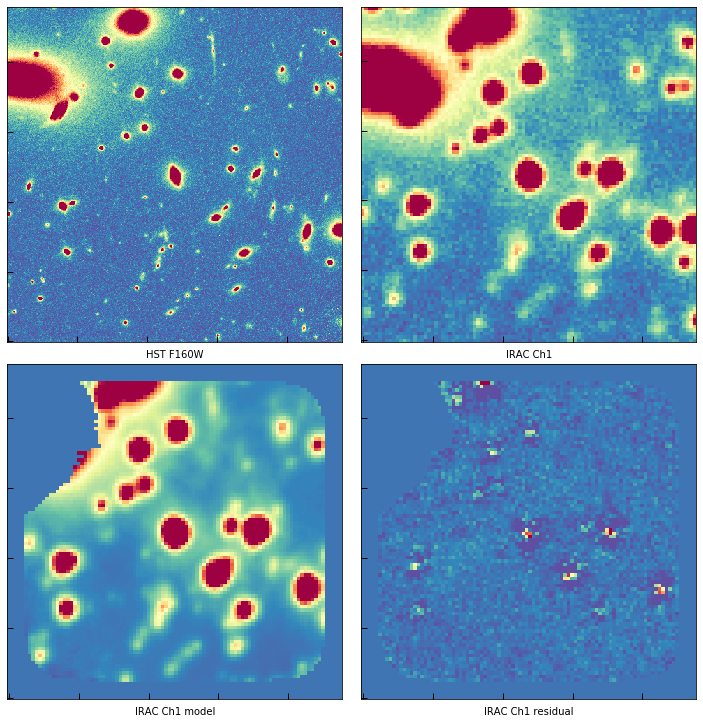

In [18]:
# Show results
fig = plt.figure(figsize=[10, 10])

cm = 'Spectral_r'
vm = (-0.03, 0.4)

ax = fig.add_subplot(221)
ax.imshow(hst_slice, vmin=vm[0]/10, vmax=vm[1]/10, cmap=cm)
ax.set_xlabel('HST F160W')

ax = fig.add_subplot(222)
ax.imshow(irac_im.data[isly, islx], vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_xlabel(f'IRAC Ch{ch}')

ax = fig.add_subplot(223)
ax.imshow(h_model*msk2d, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_xlabel(f'IRAC Ch{ch} model')

ax = fig.add_subplot(224)
ax.imshow((irac_im.data[isly, islx] - h_model)*msk2d, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_xlabel(f'IRAC Ch{ch} residual')

for ax in fig.axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
fig.tight_layout(pad=0.5)

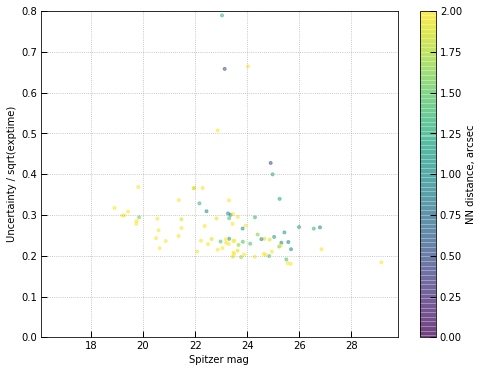

In [19]:
# Show uncertainties that account for close neighbors
fig = plt.figure(figsize=[8, 6])

plt.scatter(23.9-2.5*np.log10(flux), err*np.sqrt(expt[ids-1]/3600.), 
            alpha=0.5, c=phot['dr_nn'][ids-1], vmin=0, vmax=2) 
plt.xlabel('Spitzer mag')
plt.ylabel('Uncertainty / sqrt(exptime)')
plt.ylim(0,0.8)
plt.grid()
cb = plt.colorbar()
cb.set_label('NN distance, arcsec')

## Refine morphological models with GALFIT (experimental)

In [20]:
from grizli.galfit import galfit
tf = None
use_psf = False # Use full subsampled PSF, doesn't help much and is slower
psf_offset, wpower = 0, -1
galfit_ids = []

In [21]:
fit_ids, dil_size = [484], 11

if fit_ids[0] < 0:
    # IDs that touch
    xmsk = (seg_sl == -fit_ids[0])
    msk_dil = binary_dilation(xmsk, np.ones((dil_size,dil_size)))
    fit_ids = list(np.unique(seg_sl[msk_dil])[1:])

In [22]:
wsl = irac_wcs.slice((isly, islx))  
head = utils.to_header(wsl)

components = [galfit.GalfitSky()]
segmap = (seg_sl == 0)[pf//2::pf,pf//2::pf]

segmap &= (sivar > 0).reshape(segmap.shape)
segmap &= b_conv.reshape(segmap.shape) < 0.1

_c = _x[0]*1.

_Af = np.vstack([_Abg, _A])  

dp = (Npan-32) #//2

pop_ids = []

flux = _x[0][Nbg:Nbg+N]*1

for id_i in fit_ids:
    ix = phot['number'] == id_i
    _c[Nbg + np.arange(len(ids))[ids == id_i]] = 0
    segmap |= (seg_sl[pf//2::pf,pf//2::pf] == id_i)
    if use_psf == 2:
        components += [galfit.GalfitPSF()]
    else:
        components += [galfit.GalfitSersic(q=0.8)]#, R_e=0.5)]

    xy = wsl.all_world2pix(np.array([phot['ra'][ix], phot['dec'][ix]]).T, 1).flatten() + 0.5
    components[-1].pdict['pos'] = list(xy)
    components[-1].pdict['mag'] = 22.5
    
    if (id_i in ids) & True:
        components[-1].pdict['mag'] = 26.563-2.5*np.log10(np.maximum(flux[ids == id_i], 1))[0]
        if components[-1].pdict['mag'] > 28:
            pop_ids.append(id_i)
            components.pop(-1)
            continue
    try:
        components[-1].pdict['n'] = fixn
        components[-1].pfree['n'] = nfree
    except:
        pass
                
for id in pop_ids:
    fit_ids.pop(fit_ids.index(id))
            
h_model = _Af.T.dot(_c).reshape(h_sm.shape)
ydata = irac_im.data[isly, islx] - h_model

ds9.frame(15)
ds9.view(ydata*segmap, header=head)

ivar = (irac_sivar[isly, islx])**2
ivar = 1/(1/ivar+(0.02*ydata)**2)

if use_psf == 1:
    gf = galfit.Galfitter.fit_arrays(ydata, ivar*segmap, segmap*1, irac_psf, psf_sample=5, id=1, components=components, recenter=False, exptime=0)
else:
    gf = galfit.Galfitter.fit_arrays(ydata, ivar*segmap, segmap*1, irac_psf[pf//2::pf,pf//2::pf], psf_sample=1, id=1, components=components, recenter=False, exptime=0)

ds9.frame(15)
ds9.view(gf['resid'].data*segmap, header=head)

In [23]:
# Is the FIT OK? Replace it in the model matrix
galfit_ids += fit_ids

# Component imaage
cwd = os.getcwd()
os.chdir('/tmp/')
os.system('perl -pi -e "s/P\) 0/P\) 3/" gf.gfmodel')
os.system('galfit gf.gfmodel')
im = pyfits.open('subcomps.fits')

os.chdir(cwd)
for i, id in enumerate(fit_ids):
    gf_model = im[i+2].data.flatten()
    _A[ids == id,:] = gf_model/gf_model.sum()

# 
_Af = np.vstack([_Abg, _A])  

# Bright stars
if bright is not None:
    h_bright = _A[bright,:].T.dot(Anorm[bright])
else:
    h_bright = 0

msk = sivar > 0
msk &= h_bright*sivar < bright_sn
msk &= b_conv < 0.1
msk2d = msk.reshape(h_sm.shape)

_Ax = (_Af[:,msk]*sivar[msk]).T
_yx = (y*sivar)[msk]

#bad = ~np.isfinite(_Ax)
print('Least squares')

_x = np.linalg.lstsq(_Ax, _yx, rcond=-1)

h_model = _Af.T.dot(_x[0]).reshape(h_sm.shape)

ds9.view(msk2d*(irac_im.data[isly, islx]-h_model), header=utils.get_wcs_slice_header(irac_wcs, islx, isly))


Least squares


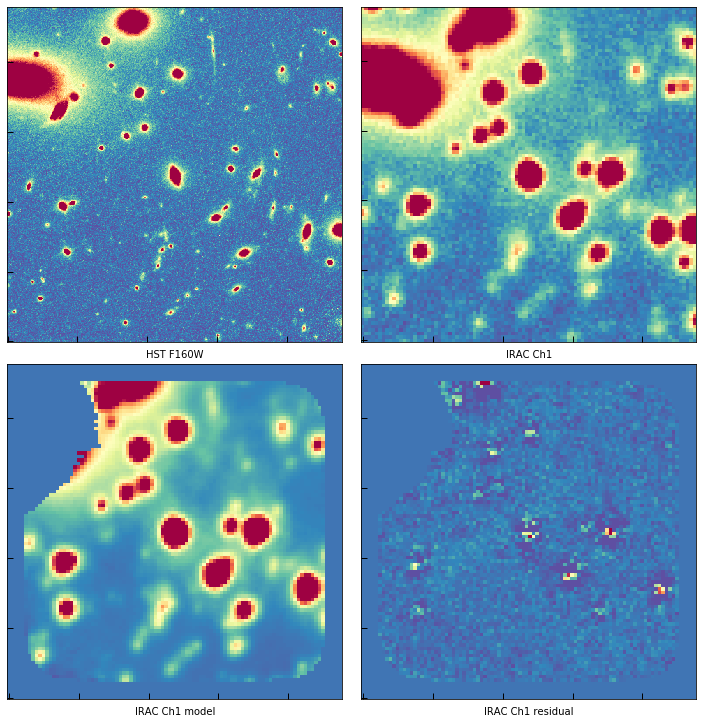

In [24]:
# Show results again after some manual galfit runs

fig = plt.figure(figsize=[10, 10])

cm = 'Spectral_r'
#cm = 'gist_earth'

#cm = golf
vm = (-0.03, 0.4)

ax = fig.add_subplot(221)
ax.imshow(hst_slice, vmin=vm[0]/10, vmax=vm[1]/10, cmap=cm)
ax.set_xlabel('HST F160W')

ax = fig.add_subplot(222)
ax.imshow(irac_im.data[isly, islx], vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_xlabel(f'IRAC Ch{ch}')

ax = fig.add_subplot(223)
ax.imshow(h_model*msk2d, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_xlabel(f'IRAC Ch{ch} model')

ax = fig.add_subplot(224)
ax.imshow((irac_im.data[isly, islx] - h_model)*msk2d, vmin=vm[0], vmax=vm[1], cmap=cm)
ax.set_xlabel(f'IRAC Ch{ch} residual')

for ax in fig.axes:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
fig.tight_layout(pad=0.5)